# Convolutional Neural Networks with PyTorch Exercise (6 points)

The homework assignment is due by the end of the day on Thursday, November 13.

You are expected to solve the assignment problems independently and adhere to the university's policies for academic honesty and integrity. Copying solutions to the assignment problems from your classmates, the internet, or anywhere else is strictly prohibited.

**Note that your solutions are expected to follow the code examples provided in the lecture notes. If your solution to a problem uses functions or codes that are not covered in the lecture notes, that will result in zero marks assigned for that problem.**

CNNs with PyTorch exercise: 6 points

Total points for Assignment 5: 25 points

## Part 1. Load the Dataset (1 point)

We will use a subset of the [WikiArt Dataset](https://paperswithcode.com/dataset/wikiart) containing 3,988 paintings by 10 artists. The artists are Cezanne, Degas, Gauguin, Hassam, Matisse, Monet, Pissarro, Renoir, Sargent, and VanGogh.

The file `Paintings.zip` in the `data` directory contains a subdirectory called `images` that contains all 3,988 images, a file `labels.csv` with the labels for all images, and a file `label_names.csv` with the names of the painters that correspond to the labels.

Follow the explanations in Lecture 17 and load the Paintings dataset. During the data loading, resize the images to 224x224 pixels size.

In [3]:
import os
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from sklearn.model_selection import train_test_split
from google.colab import drive

print("Mounting Google Drive...")
drive.mount('/content/drive')

ROOT_DIR = "/content/drive/MyDrive/Assignment_5_October_31/data/Paintings"

if not os.path.isdir(ROOT_DIR):
    print("\nERROR: The 'Paintings' folder was not found at the expected location:")
    print(f"       {ROOT_DIR}")
    print("Please ensure your Google Drive is mounted and the folder path is correct.")
else:
    print(f"\nDataset root folder found at: {ROOT_DIR}")


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

print("\nImage transformations defined: Resize to 224x224, then ToTensor.")

class PaintingsDataset(Dataset):
    """Custom PyTorch Dataset for the Paintings data, inheriting from Dataset."""
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'images')
        self.labels_file = pd.read_csv(os.path.join(root_dir, 'labels.csv'), header=None)
        self.transform = transform

    def __len__(self):
        return len(self.labels_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, f'img_{idx + 1:04}.jpg')

        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = int(self.labels_file.iloc[idx, 0])
        return image, label

BATCH_SIZE = 64

Mounting Google Drive...
Mounted at /content/drive

Dataset root folder found at: /content/drive/MyDrive/Assignment_5_October_31/data/Paintings

Image transformations defined: Resize to 224x224, then ToTensor.


Instantiate the train, test, and validation datasets. Use 20% for testing, and 20% of the initial training set for validation. Print the number of samples in the train, test, and validation datasets.

In [4]:
from torch.utils.data import Subset

paintings_dataset = PaintingsDataset(root_dir=ROOT_DIR, transform=transform)

print(f"\nTotal number of images loaded: {len(paintings_dataset)} (Expected 3988)")

indices_all = list(range(len(paintings_dataset)))
train_val_indices, test_indices = train_test_split(indices_all, test_size=0.2, random_state=123)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.2, random_state=123)

train_subset = Subset(paintings_dataset, train_indices)
test_subset = Subset(paintings_dataset, test_indices)
val_subset = Subset(paintings_dataset, val_indices)

# Print the number of samples in each dataset
print("--- Dataset Sample Counts ---")
print(f"Total Samples: {len(paintings_dataset)}")
print(f"Training Samples (80% of 80%): {len(train_subset)}")
print(f"Validation Samples (20% of 80%): {len(val_subset)}")
print(f"Testing Samples (20% of Total): {len(test_subset)}")

print(f"Sum of subsets: {len(train_subset) + len(val_subset) + len(test_subset)}")


Total number of images loaded: 3988 (Expected 3988)
--- Dataset Sample Counts ---
Total Samples: 3988
Training Samples (80% of 80%): 2552
Validation Samples (20% of 80%): 638
Testing Samples (20% of Total): 798
Sum of subsets: 3988


Use `DataLoader` to create iterable objects over batches of images and labels for the datasets. Select a batch size of 64 images and labels.

In [5]:
BATCH_SIZE = 64
print(f"Batch size set to: {BATCH_SIZE}")

train_dataloader = DataLoader(
    dataset=train_subset,
    shuffle=True,
    batch_size=BATCH_SIZE
)

# Validation DataLoader
val_dataloader = DataLoader(
    dataset=val_subset,
    shuffle=False,
    batch_size=BATCH_SIZE
)

# Testing DataLoader
test_dataloader = DataLoader(
    dataset=test_subset,
    shuffle=False,
    batch_size=BATCH_SIZE
)

print("\nDataLoader objects successfully created:")
print(f"- Training DataLoader size (batches): {len(train_dataloader)}")
print(f"- Validation DataLoader size (batches): {len(val_dataloader)}")
print(f"- Testing DataLoader size (batches): {len(test_dataloader)}")

try:
    batch_images, batch_labels = next(iter(train_dataloader))
    print("\nFirst batch inspection:")
    print(f"Batch images shape: {batch_images.size()}")
    print(f"Batch labels shape: {batch_labels.size()}")
except Exception as e:
    print(f"\nCould not inspect a batch (This is normal if the previous dataset setup failed): {e}")

print("\nDataLoaders are ready for the training loop.")

Batch size set to: 64

DataLoader objects successfully created:
- Training DataLoader size (batches): 40
- Validation DataLoader size (batches): 10
- Testing DataLoader size (batches): 13

First batch inspection:
Batch images shape: torch.Size([64, 3, 224, 224])
Batch labels shape: torch.Size([64])

DataLoaders are ready for the training loop.


Use the `make_grid()` function to plot images from the training dataset.

In [7]:
import matplotlib.pyplot as plt
import torchvision
import numpy as np

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of random training images and labels
try:
    images, labels = next(iter(train_dataloader))
except NameError:
    print("ERROR: 'train_dataloader' is not defined. Please run the previous data loading/DataLoader cells first.")
    raise
except StopIteration:
    print("ERROR: Could not get a batch from 'train_dataloader'. The dataloader might be empty or exhausted.")
    raise

print(f"Displaying a batch of {len(images)} images (Batch Size: {images.size(0)})")
plt.figure(figsize=(12, 12))
imshow(torchvision.utils.make_grid(images))

Output hidden; open in https://colab.research.google.com to view.

## Part 2. Define the Model (1 point)

Let's use again a pretrained VGG-16 model. Create an instance of the model, e.g., called `model_1` and replace the final layer with a custom layer to output 10 class probabilities.

In [6]:
import torch.nn as nn
from torchvision.models import vgg16

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

try:
    from torchvision.models import VGG16_Weights
    model_1 = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    print("\nVGG-16 model loaded with ImageNet weights.")
except ImportError:
    model_1 = vgg16(pretrained=True)
    print("\nVGG-16 model loaded using deprecated 'pretrained=True'.")

num_classes = 10
model_1.classifier._modules['6'] = nn.Linear(
    in_features=4096,
    out_features=num_classes
)

print(f"Replaced the final layer to output {num_classes} features.")

model_1.to(device)

print("\n--- Final Model Architecture (Snippet) ---")
print(model_1.classifier)

print("\nModel is ready for training on the 10-class dataset.")

Using device: cuda
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:03<00:00, 181MB/s]



VGG-16 model loaded with ImageNet weights.
Replaced the final layer to output 10 features.

--- Final Model Architecture (Snippet) ---
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

Model is ready for training on the 10-class dataset.


Move the model to the GPU device.

In [7]:
if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device was not previously defined. Using device: {device}")

if 'model_1' in locals():
    model_1.to(device)
    print(f"\nModel has been successfully moved to the {device} device.")
else:
    print("\nERROR: 'model_1' (the VGG-16 instance) is not defined.")
    print("Please run the previous code cell (VGG-16 model loading and modification) first.")


Model has been successfully moved to the cuda device.


## Part 3. Train and Evaluate the Model (2 points)

Train the model, plot the learning curves, and evaluate the performance on the test dataset. Use Adam optimizer with 1e-4 learning rate. The expected test accuracy should be around 70%.

Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.0001

--- Starting Model Training ---
Epoch: 1/10	 Training loss: 0.0746	 Training accuracy: 97.727%	 Validation accuracy: 68.495%
Epoch: 2/10	 Training loss: 0.0878	 Training accuracy: 97.375%	 Validation accuracy: 59.091%
Epoch: 3/10	 Training loss: 0.0401	 Training accuracy: 98.785%	 Validation accuracy: 62.069%
Epoch: 4/10	 Training loss: 0.0059	 Training accuracy: 99.804%	 Validation accuracy: 69.749%
Epoch: 5/10	 Training loss: 0.0016	 Training accuracy: 99.961%	 Validation accuracy: 70.533%
Epoch: 6/10	 Training loss: 0.0002	 Training accuracy: 100.000%	 Validation accuracy: 69.749%
Epoch: 7/10	 Training loss: 0.0001	 Training accuracy: 100.000%	 Validation accuracy: 70.219%
Epoch: 8/10	 Training loss: 0.0000	 Training accuracy: 100.000%	 Validation accuracy: 70.376%
Epoch: 9/10	 Training loss: 0.0000	 Training accuracy: 100.000%	 Validation accuracy: 70.376%
Epoch: 10/10	 Training loss: 0.0000	 Training accura

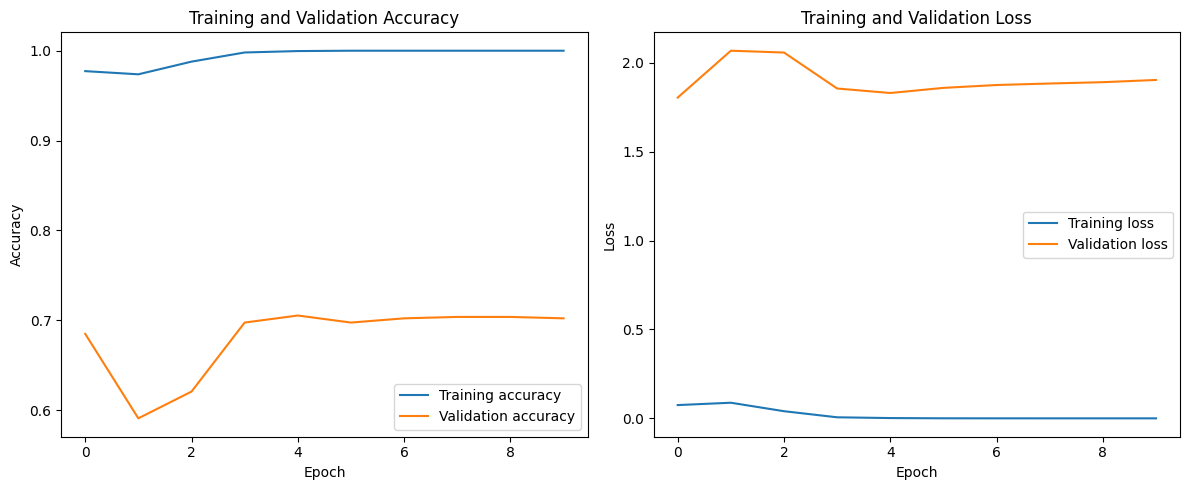


--- Model Evaluation on Test Dataset ---
Test dataset loss: 2.2719
Test dataset accuracy: 67.544%


In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model_1.parameters(), lr=LEARNING_RATE)

print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__} with learning rate {LEARNING_RATE}")

def train(model, train_loader, criterion, optimizer, device):
    """Trains the model for one epoch and returns loss and accuracy."""
    running_loss, total, sum_correct = 0.0, 0, 0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        predicted = outputs.argmax(dim=1)
        sum_correct += (predicted == labels).sum().item()
        total += batch_size

    return sum_correct / total, running_loss / total

def validate(model, val_loader, criterion, device):
    """Evaluates the model on the given dataset and returns loss and accuracy."""
    running_loss, total, sum_correct = 0.0, 0, 0
    model.eval()

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            predicted = outputs.argmax(dim=1)
            sum_correct += (predicted == labels).sum().item()
            total += batch_size

    return sum_correct / total, running_loss / total

# Model Training Loop

EPOCH_NUM = 10

training_loss_plot = []
training_accuracy_plot = []
val_loss_plot = []
val_accuracy_plot = []

print("\n--- Starting Model Training ---")
for epoch in range(EPOCH_NUM):
    tr_accuracy, tr_loss = train(model_1, train_dataloader, criterion, optimizer, device)

    val_accuracy, val_loss = validate(model_1, val_dataloader, criterion, device)

    training_accuracy_plot.append(tr_accuracy)
    training_loss_plot.append(tr_loss)
    val_accuracy_plot.append(val_accuracy)
    val_loss_plot.append(val_loss)

    print(f'Epoch: {epoch + 1}/{EPOCH_NUM}\t Training loss: {tr_loss:.4f}\t',
          f'Training accuracy: {100*tr_accuracy:2.3f}%\t Validation accuracy: {100*val_accuracy:2.3f}%')

print("--- Training Finished ---")

# Plot Learning Curves

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy_plot, label='Training accuracy')
plt.plot(val_accuracy_plot, label='Validation accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(training_loss_plot, label='Training loss')
plt.plot(val_loss_plot, label='Validation loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

test_accuracy, test_loss = validate(model_1, test_dataloader, criterion, device)

print(f'\n--- Model Evaluation on Test Dataset ---')
print(f'Test dataset loss: {test_loss:.4f}')
print(f'Test dataset accuracy: {100*test_accuracy:2.3f}%')

## Part 4. Train and Evaluate the Model with a Pretrained ResNet50 Model (1 point)

Similarly to the VGG-16 model, import a pretrained ResNet50 model as `model_2`, and afterward train and evaluate the model on the Paintings dataset. Similarly to `model_1` use Adam optimizer with a learning rate of 1e-4. The expected test accuracy should be around 80%.

--- ResNet50 Model Setup ---
ResNet50 model loaded with high-quality ImageNet weights.
Replaced the final layer (fc) to output 10 features using 2048 input features.
Fine-Tuning Setup: All ResNet50 layers are now UNFROZEN for full training.
Optimizer: Adam with learning rate 0.0001
--------------------------------------------------
--- Starting ResNet50 Fine-Tuning for 10 Epochs ---
Epoch: 01/10	 Tr. Loss: 1.9883	 Tr. Acc: 39.07%	 Val. Acc: 53.13%
Epoch: 02/10	 Tr. Loss: 0.9832	 Tr. Acc: 73.32%	 Val. Acc: 67.87%
Epoch: 03/10	 Tr. Loss: 0.3915	 Tr. Acc: 89.62%	 Val. Acc: 72.73%
Epoch: 04/10	 Tr. Loss: 0.1485	 Tr. Acc: 96.79%	 Val. Acc: 73.35%
Epoch: 05/10	 Tr. Loss: 0.0596	 Tr. Acc: 99.18%	 Val. Acc: 73.67%
Epoch: 06/10	 Tr. Loss: 0.0246	 Tr. Acc: 99.80%	 Val. Acc: 75.71%
Epoch: 07/10	 Tr. Loss: 0.0122	 Tr. Acc: 99.92%	 Val. Acc: 74.61%
Epoch: 08/10	 Tr. Loss: 0.0094	 Tr. Acc: 99.92%	 Val. Acc: 75.55%
Epoch: 09/10	 Tr. Loss: 0.0056	 Tr. Acc: 100.00%	 Val. Acc: 75.24%
Epoch: 10/10	 Tr. L

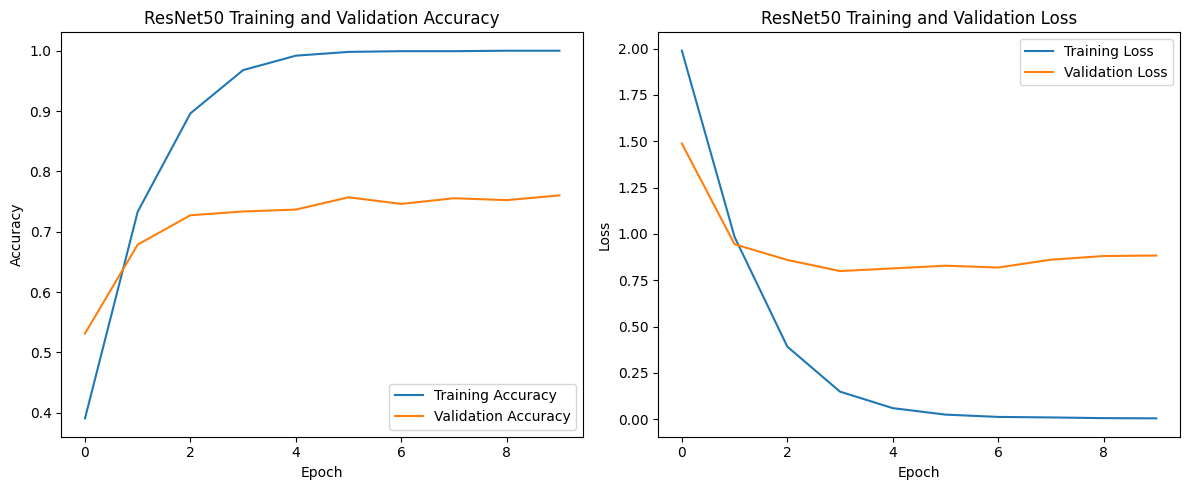


--- FINAL ResNet50 EVALUATION on Test Dataset ---
Test dataset loss: 0.8993
Test dataset accuracy: 74.185%


In [11]:
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import torch.optim as optim
import time

criterion = nn.CrossEntropyLoss()
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
EPOCH_NUM = 10

print("--- ResNet50 Model Setup ---")

try:
    model_2 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    print("ResNet50 model loaded with high-quality ImageNet weights.")
except ImportError:
    model_2 = resnet50(pretrained=True)
    print("ResNet50 model loaded using deprecated 'pretrained=True'.")

INPUT_FEATURES_RESNET50 = 2048

model_2.fc = nn.Linear(INPUT_FEATURES_RESNET50, NUM_CLASSES)
print(f"Replaced the final layer (fc) to output {NUM_CLASSES} features using {INPUT_FEATURES_RESNET50} input features.")

model_2.to(device)

for param in model_2.parameters():
    param.requires_grad = True
print("Fine-Tuning Setup: All ResNet50 layers are now UNFROZEN for full training.")

optimizer_2 = optim.Adam(model_2.parameters(), lr=LEARNING_RATE)
print(f"Optimizer: {optimizer_2.__class__.__name__} with learning rate {LEARNING_RATE}")
print("-" * 50)


def train(model, train_loader, criterion, optimizer, device):
    """Trains the model for one epoch and returns loss and accuracy."""
    running_loss, total, sum_correct = 0.0, 0, 0
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        predicted = outputs.argmax(dim=1)
        sum_correct += (predicted == labels).sum().item()
        total += batch_size
    return sum_correct / total, running_loss / total

def validate(model, val_loader, criterion, device):
    """Evaluates the model on the given dataset and returns loss and accuracy."""
    running_loss, total, sum_correct = 0.0, 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            predicted = outputs.argmax(dim=1)
            sum_correct += (predicted == labels).sum().item()
            total += batch_size
    return sum_correct / total, running_loss / total

training_loss_plot_2 = []
training_accuracy_plot_2 = []
val_loss_plot_2 = []
val_accuracy_plot_2 = []

print(f"--- Starting ResNet50 Fine-Tuning for {EPOCH_NUM} Epochs ---")
start_time = time.time()

for epoch in range(EPOCH_NUM):
    tr_accuracy, tr_loss = train(model_2, train_dataloader, criterion, optimizer_2, device)
    val_accuracy, val_loss = validate(model_2, val_dataloader, criterion, device)

    training_accuracy_plot_2.append(tr_accuracy)
    training_loss_plot_2.append(tr_loss)
    val_accuracy_plot_2.append(val_accuracy)
    val_loss_plot_2.append(val_loss)

    print(f'Epoch: {epoch + 1:02d}/{EPOCH_NUM}\t Tr. Loss: {tr_loss:.4f}\t',
          f'Tr. Acc: {100*tr_accuracy:5.2f}%\t Val. Acc: {100*val_accuracy:5.2f}%')

end_time = time.time()
print(f"--- Training Finished in {int(end_time - start_time)} seconds ---")

plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(training_accuracy_plot_2, label='Training Accuracy')
plt.plot(val_accuracy_plot_2, label='Validation Accuracy')
plt.legend()
plt.title('ResNet50 Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(training_loss_plot_2, label='Training Loss')
plt.plot(val_loss_plot_2, label='Validation Loss')
plt.legend()
plt.title('ResNet50 Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

test_accuracy_2, test_loss_2 = validate(model_2, test_dataloader, criterion, device)

print(f'\n--- FINAL ResNet50 EVALUATION on Test Dataset ---')
print(f'Test dataset loss: {test_loss_2:.4f}')
print(f'Test dataset accuracy: {100*test_accuracy_2:5.3f}%')


## Part 5. Save and Load the Model Parameters (1 point)

Save the state dictionary for `model_2`.

In [12]:
import torch
import os

if not os.path.isdir('/content/drive'):
    drive.mount('/content/drive')
    print("Google Drive mounted.")

SAVE_DIR = "/content/drive/MyDrive/Assignment_5_October_31"
MODEL_FILE_NAME = "ResNet50_model_2_state_dict.pth"
SAVE_PATH = os.path.join(SAVE_DIR, MODEL_FILE_NAME)

if 'model_2' not in locals():
    print("ERROR: 'model_2' (the ResNet50 instance) is not defined.")
    print("Please run the ResNet50 model setup and training code cell first.")
else:
    torch.save(model_2.state_dict(), SAVE_PATH)

    print(f"\nSuccessfully saved the state dictionary for model_2 to:")
    print(f"Path: {SAVE_PATH}")
    print("\nVerification: Check your Google Drive folder to confirm the file exists.")


Successfully saved the state dictionary for model_2 to:
Path: /content/drive/MyDrive/Assignment_5_October_31/ResNet50_model_2_state_dict.pth

Verification: Check your Google Drive folder to confirm the file exists.


Load the state dictionary and evaluate the performance on the test dataset to ensure that the accuracy is the same.

In [13]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader

LOAD_PATH = "/content/drive/MyDrive/Assignment_5_October_31/ResNet50_model_2_state_dict.pth"
print(f"Attempting to load state dictionary from: {LOAD_PATH}")

if not os.path.isdir('/content/drive/MyDrive'):
    drive.mount('/content/drive')
    print("Google Drive mounted.")

NUM_CLASSES = 10
INPUT_FEATURES_RESNET50 = 2048

try:
    loaded_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
except:
    loaded_model = resnet50(pretrained=False)
loaded_model.fc = nn.Linear(INPUT_FEATURES_RESNET50, NUM_CLASSES)
print("Empty ResNet50 model structure successfully instantiated.")

state_dict = torch.load(LOAD_PATH)

loaded_model.load_state_dict(state_dict)
print("Saved weights successfully loaded into the model structure.")

if 'device' not in locals():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Device set to: {device}")

loaded_model.to(device)

if 'validate' not in locals():
    print("\nERROR: The 'validate' function is missing from the environment.")
    print("Please run the training code cell once to define the 'validate' function.")
elif 'test_dataloader' not in locals():
    print("\nERROR: The 'test_dataloader' is missing from the environment.")
    print("Please run the data loading and DataLoader setup cells first.")
else:
    test_accuracy_loaded, test_loss_loaded = validate(loaded_model, test_dataloader, criterion, device)

    print(f'\n--- EVALUATION OF LOADED MODEL ---')
    print(f'Test dataset loss (Loaded Model): {test_loss_loaded:.4f}')
    print(f'Test dataset accuracy (Loaded Model): {100*test_accuracy_loaded:5.3f}%')
    print("\nThis accuracy should match the final accuracy obtained before saving.")

Attempting to load state dictionary from: /content/drive/MyDrive/Assignment_5_October_31/ResNet50_model_2_state_dict.pth
Empty ResNet50 model structure successfully instantiated.
Saved weights successfully loaded into the model structure.

--- EVALUATION OF LOADED MODEL ---
Test dataset loss (Loaded Model): 0.8993
Test dataset accuracy (Loaded Model): 74.185%

This accuracy should match the final accuracy obtained before saving.
